In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# 1. Install dependencies (in Kaggle notebook cell)
!pip install diffusers transformers accelerate scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [2]:
# !unzip /kaggle/input/carvana-image-masking-challenge/test.zip -d /kaggle/working/my_data
!unzip -q /kaggle/input/carvana-image-masking-challenge/test.zip -d /kaggle/working/test -x "*.jpg"


In [3]:
!ls /kaggle/working/my_data/test

ls: cannot access '/kaggle/working/my_data/test': No such file or directory


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import glob
import os
import random
from diffusers import StableDiffusionInpaintPipeline, DDIMScheduler
from transformers import CLIPTokenizer, CLIPTextModel
import matplotlib.pyplot as plt
from tqdm import tqdm




2025-11-13 07:38:48.407780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763019528.594968      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763019528.641563      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [5]:
import torch
from torch import nn
import numpy as np
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline
import os

# --------------------------- U-NET --------------------------- #
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder (upsampling)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        # Output layer
        self.out = nn.Conv2d(64, out_channels, 1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder with skip connections
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder with skip connections
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Output with sigmoid activation
        out = torch.sigmoid(self.out(d1))
        return out




# --------------------------- PIPELINE --------------------------- #
class DiffEditPipeline:
    def __init__(self, unet_model, inpaint_model_id="runwayml/stable-diffusion-inpainting", device="cuda:1"):
        self.device = device
        self.unet_model = unet_model
        self.unet_model.eval()
        print("✓ Pre-trained U-Net loaded into pipeline!")
    
        print(f"\nLoading inpainting model on {device}: {inpaint_model_id}")
        self.pipe = StableDiffusionInpaintPipeline.from_pretrained(
            inpaint_model_id,
            torch_dtype=torch.float16 if device.type == "cuda" else torch.float32
        ).to(device)
        self.pipe.enable_attention_slicing()
        print("✓ Inpainting model loaded!")

    # --------------------------- MASK GENERATION --------------------------- #
    def generate_mask(self, image, mask_threshold=0.3):
        """Generate proper binary mask using pre-trained U-Net trained on cars"""
        # Resize to 256x256 (match U-Net training size)
        img_resized = image.resize((256, 256))
        img_np = np.array(img_resized).astype(np.float32) / 255.0
        img_tensor = torch.from_numpy(img_np).permute(2,0,1).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            pred_mask = self.unet_model(img_tensor)
        
        # Threshold mask
        binary_mask = (pred_mask > mask_threshold).float()
        # Resize mask back to original image size
        mask_np = binary_mask[0, 0].cpu().numpy()
        mask_pil = Image.fromarray((mask_np*255).astype(np.uint8)).resize(image.size)
        
        coverage = (np.array(mask_pil) > 0).sum() / (mask_pil.size[0]*mask_pil.size[1]) * 100
        print(f"✓ Mask generated! Coverage: {coverage:.1f}%")
        
        return mask_pil


    # --------------------------- DIFFEDIT INPAINT --------------------------- #
    def diffedit(self, image_path, prompt, mask_threshold=0.3, guidance_scale=7.5, num_inference_steps=50, save_intermediates=False, output_dir="outputs"):
        image = Image.open(image_path).convert("RGB")
        mask = self.generate_mask(image, mask_threshold=mask_threshold)

        result = self.pipe(
            prompt=prompt,
            image=image,
            mask_image=mask,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps
        ).images[0]

        if save_intermediates:
            os.makedirs(output_dir, exist_ok=True)
            base_name = os.path.basename(image_path)
            result.save(os.path.join(output_dir, f"edited_{base_name}"))
            mask.save(os.path.join(output_dir, f"mask_{base_name}"))

        return result, mask


In [6]:
# === LOAD PRETRAINED U-NET MODEL ===
model_path = "/kaggle/input/cocounet/unet_coco_best.pth"

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
unet_model = UNet(in_channels=3, out_channels=1)
unet_model.load_state_dict(torch.load(model_path, map_location=device))
unet_model.to(device)
unet_model.eval()
print("✓ Pre-trained U-Net loaded successfully!")

# === INITIALIZE DIFFEDIT PIPELINE ===
pipeline = DiffEditPipeline(unet_model=unet_model, device=device)

# === EDIT IMAGE ===
image_path = "/kaggle/input/0a0e3fb8f782-03/0a0e3fb8f782_03.jpg"
prompt = "a cycle"

result, mask = pipeline.diffedit(
    image_path=image_path,
    prompt=prompt,
    mask_threshold=0.3,
    guidance_scale=10,
    num_inference_steps=50,
    save_intermediates=True,
    output_dir="diffedit_outputs"
)


✓ Pre-trained U-Net loaded successfully!
✓ Pre-trained U-Net loaded into pipeline!

Loading inpainting model on cuda:1: runwayml/stable-diffusion-inpainting


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


✓ Inpainting model loaded!
✓ Mask generated! Coverage: 36.5%


  0%|          | 0/50 [00:00<?, ?it/s]

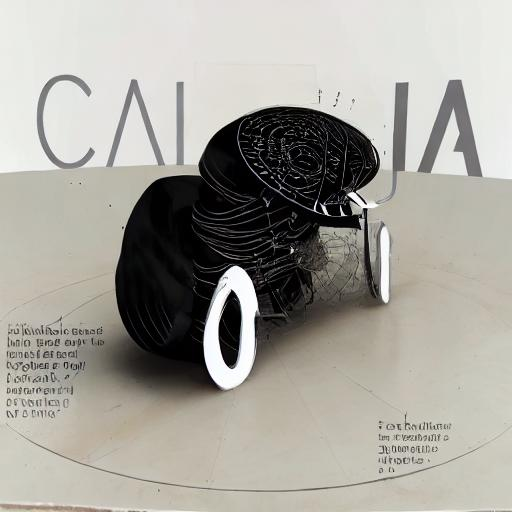

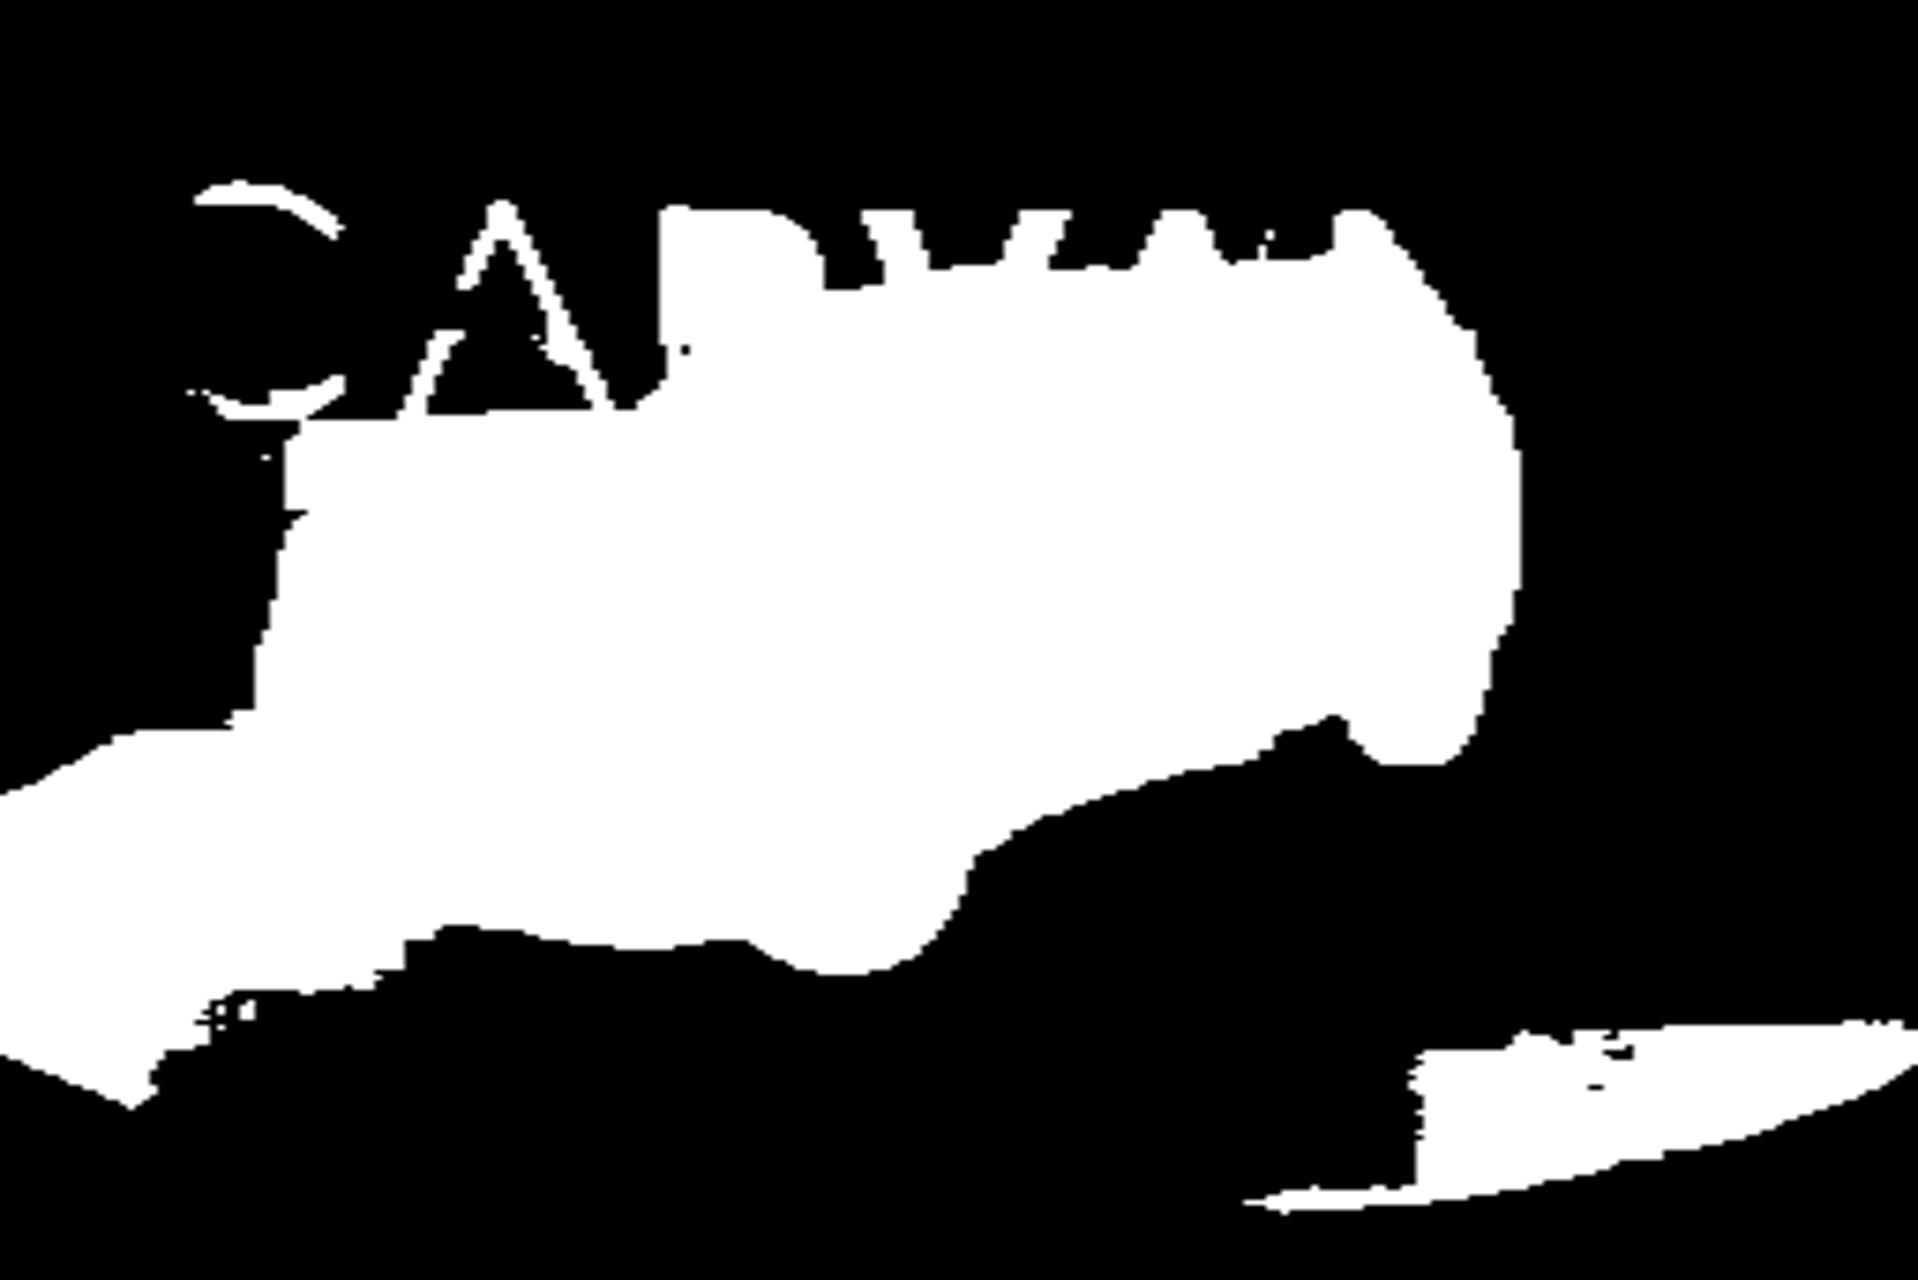

In [7]:
import os
from IPython.display import Image, display

folder = "/kaggle/working/diffedit_outputs"

# Get all image files (common formats)
image_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Display all images
for img_path in image_files:
    display(Image(filename=img_path))
